In [1]:
import datetime; import time
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dateutil.relativedelta import relativedelta
import netCDF4 as nc
from Utils.readData  import *
from Utils.filter_query import *
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.sparse import csr_matrix, coo_matrix, csc_matrix
from scipy import sparse
from scipy.sparse.linalg import inv
import cupyx.scipy.sparse.linalg
import torch, time
from tqdm import tqdm

In [2]:
### Different grids to use
# Full grid used for footprints
full_xLim = [ -125.0, -120.0 ]
full_yLim = [   36.0,   40.0 ]
big_xLim,big_yLim = full_xLim,full_yLim
# Medium sized grid
medium_xLim = [-123.60,-121.60]
medium_yLim = [  36.80,  38.60]
med_xLim,med_yLim = medium_xLim,medium_yLim
# Bay Area domain (smallest grid)
BayArea_xLim = [-123.10,-121.80]
BayArea_yLim = [  37.35,  38.40]
small_xLim,small_yLim = BayArea_xLim,BayArea_yLim
# Inversion grid to use
Inv_lonLim = small_xLim
Inv_latLim = small_yLim

In [3]:
start_time = datetime.datetime(2018, 1, 1, 0, 0)
end_time = datetime.datetime(2018, 1, 3, 0, 0)

In [4]:
lats = np.linspace(36, 40, 481)
lons = np.linspace(-125, -120, 601)

In [5]:
footprint_directory = "/home/disk/hermes/data/footprints/BEACO2N/obs/"
emission_directory = "/home/disk/hermes/data/emissions/BEACO2N/"

footprint_files = get_files(footprint_directory)
emission_files = get_files(emission_directory)
emission_files.sort()
footprint_files.sort()
print(len(footprint_files), len(emission_files))

490646 27049


In [6]:
np.float32(1.0)

1.0

In [7]:
emission_filtered_files, emission_files_df = filter_emissions(emission_files, [start_time, end_time])
foot_filtered_files, foot_files_df = filter_obs(footprint_files, Inv_lonLim, Inv_latLim, agl_domain='')

In [8]:
# filtering footprint_files
domain_foot_files = list(foot_files_df[(foot_files_df['time']>=start_time)&(foot_files_df['time']<end_time)]['file'])

In [9]:
nrow = 481
ncol = 601
m = nrow*ncol

m_start = start_time-datetime.timedelta(hours=71)
m_end = end_time-datetime.timedelta(hours=1)
date_range_integrated = pd.date_range(start=start_time, end=m_end, freq='1h')
# time_dict = {}
# for idx, value in enumerate(date_range):
#     time_dict[value] = idx
# m_start, m_end

In [10]:
model_error = {
    0:3,
    1:3,
    2:3,
    3:3,
    4:3,
    5:3,
    6:4,
    7:5,
    8:8,
    9:6,
    10:4,
    11:2,
    12:1,
    13:1,
    14:1,
    15:1,
    16:2,
    17:4,
    18:6,
    19:8,
    20:6,
    21:4,
    22:3,
    23:3,
}

In [11]:
# # global H, Y, So_d
# # H = np.zeros((len(domain_foot_files), date_range_integrated.shape[0]*m))
# # Y = np.zeros((len(domain_foot_files), 1))
# # So_d = np.zeros((len(domain_foot_files), 1))

def flatten_2d_column(foot):
    sub_foot = np.zeros((foot.shape[0]*foot.shape[1]))
    for idx in range(foot.shape[1]):
        sub_foot[idx*foot.shape[0]:(idx+1)*foot.shape[0]] = foot[:, idx]
    return sub_foot

# # def fill_h(idx, foot_file):
# #     global H, Y, So_d
# #     [__, timestamp, receptor_lon, receptor_lat, receptor_agl] = foot_file.replace('.nc', '').split("_")
# #     year = int(timestamp[0:4])
# #     month = int(timestamp[4:6])
# #     day = int(timestamp[6:8])
# #     hour = int(timestamp[8:])
# #     time_foot = datetime.datetime(year, month, day, hour)
# #     index = time_dict[time_foot]
# #     # print(H[idx, index*m:(index+1)*m].shape, 481*601)
    
# #     foot_data = nc.Dataset(foot_file)
# #     foot = np.array(foot_data['foot'])
# #     Y[idx, 0] = np.array(foot_data['co2'])[0] - np.array(foot_data['bkg_co2_NOAA'])[0]
# #     obs_error = np.array(foot_data['co2_err'])[0]
# #     bkg_error = np.array(foot_data['bkg_err_NOAA'])[0]
# #     mod_error = model_error[time_foot.hour]
# #     So_d[idx, 0] = obs_error**2+bkg_error**2+mod_error**2
# #     # return_foot = np.zeros((1, date_range.shape[0]*m))
# #     resolved_time_list = date_range[date_range<=time_foot][-foot.shape[0]:]
# #     for jdx, time_hour in enumerate(resolved_time_list):
# #         m_index = time_dict[time_hour]
# #         # print(m_index, time_hour, jdx)
# #         H[idx, m_index*m:(m_index+1)*m] = flatten_2d_column(foot[jdx, :, :])
# #     return

# # def fill_h_parallel():
# #     # print("filling H ...")
# #     # H = np.zeros((len(domain_foot_files), date_range.shape[0]*m))
# #     OUTPUT = Parallel(n_jobs=-1, verbose=10, backend='threading')(delayed(fill_h)(idx, foot_file) for idx, foot_file in enumerate(domain_foot_files))
# #     # for value in OUTPUT:
# #     #     index = value[1]
# #     #     data = value[0]
# #     #     H[index, :] = data
# #     # return H
# # fill_h_parallel()

# count = 0
# for idx in range(H.shape[0]):
#     for val in H[250, :]:
#         if val!=0:
#             count += 1
#     break
# count

# X = np.zeros((date_range.shape[0]*m, 1))
# for ems_file in tqdm(emission_filtered_files):
#     trimmed_file = ems_file.split("/")[-1].replace("_", "x")
#     [_, year, month, day, hour] = trimmed_file.replace('.ncdf', '').split("x")
#     year = int(year)
#     month = int(month)
#     day = int(day)
#     hour = int(hour)
#     timestamp = datetime.datetime(year, month, day, hour)
#     ems_data = np.array(nc.Dataset(ems_file)['flx_total'])
#     ems_flattened = flatten_2d_column(ems_data)
#     index = time_dict[timestamp]
#     X[index*m:(index+1)*m, 0] = ems_flattened

In [12]:
def get_background_error(data, bkg_conc_noaa, bkg_conc_nasa, bkg_conc_ameriflux, bkg_err_noaa, bkg_err_nasa, bkg_err_ameriflux):
    source = ''
    bkg_conc = bkg_conc_noaa
    bkg_err = max(bkg_err_nasa, bkg_err_noaa)
    if bkg_err_nasa > bkg_err_noaa:
        source = 'nasa'
    else:
        source = 'noaa'
    if bkg_err == -999.0: #nan value auto fill in netcdf file
        if bkg_err_nasa == -999.0 and bkg_err_noaa == -999.0:
            bkg_err = np.nan
        elif bkg_err_nasa == -999.0:
            source = 'noaa'
            bkg_err = bkg_err_noaa
        elif big_err_noaa == -999.0:
            source = 'nasa'
            bkg_err = bkg_err_nasa
    
    ameriflux_lon = -121.8
    ameriflux_lat =   38.2
    maxDist       =   25.0 # maximum allowable distance from the AmeriFlux site
    end_lon = np.array(data['end_lon'])[0]
    end_lat = np.array(data['end_lat'])[0]
    end_agl = np.array(data['end_agl'])[0]
    amf_lon = np.array(data['ameriflux_lon'])[0]
    amf_lat = np.array(data['ameriflux_lat'])[0]
    amf_agl = np.array(data['ameriflux_agl'])[0]
    amf_time = np.array(data['ameriflux_julian'])[0]
    amf_dist = 110*np.sqrt((amf_lon-ameriflux_lon)**2 + (amf_lat-ameriflux_lat)**2)
    # amfUSE  = amfDist .< maxDist
    if amf_dist < maxDist:
        source = 'ameriflux'
        bkg_conc = bkg_conc_ameriflux
        bkg_err = max(bkg_err, bkg_err_ameriflux)
    return bkg_conc, bkg_err, source

# Time integrated

In [24]:
date_range_integrated = pd.date_range(start=start_time, end=m_end, freq='1h')
time_dict_integrated = {}
for idx, timestamp in enumerate(date_range_integrated):
    time_dict_integrated[timestamp] = idx

In [25]:
source_list = []
for foot_file in tqdm(domain_foot_files):
    # print(foot_file)
    data = nc.Dataset(foot_file)
    bkg_conc_noaa = np.array(data['bkg_co2_NOAA'])[0]
    bkg_conc_nasa = np.array(data['bkg_co2_NASA'])[0]
    bkg_conc_ameriflux = np.array(data['ameriflux_co2'])[0]
    bkg_err_noaa = np.array(data['bkg_err_NOAA'])[0]
    bkg_err_nasa = np.array(data['bkg_err_NASA'])[0]
    bkg_err_ameriflux = np.array(data['ameriflux_err'])[0]
    bkg_conc, bkg_err, source = get_background_error(data, bkg_conc_noaa, bkg_conc_nasa, bkg_conc_ameriflux, bkg_err_noaa, bkg_err_nasa, bkg_err_ameriflux)
    source_list.append(source)
    print(foot_file, bkg_conc, bkg_err, source)

  3%|███▏                                                                                                            | 13/453 [00:00<00:06, 63.60it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.155_37.754_3.nc 410.5341 1.7871917 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.175_37.737_3.nc 410.50128 1.7051164 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.181_37.819_9.nc 410.57358 1.7891294 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.196_37.736_7.8232.nc 410.36023 1.7625825 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.205_37.809_7.nc 410.49258 1.830374 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.237_37.804_9.528.nc 410.43845 1.789604 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.24_37.848_24.nc 410.6054 1.8002934 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.252_37.876_10.3.nc 410.58 1.7984264 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.277_37.833_3.nc 410.5224 1.8018881 noaa
/home/disk/hermes/data/footprints

  4%|████▉                                                                                                           | 20/453 [00:00<00:07, 59.96it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.335_37.995_5.033.nc 410.50668 1.7551851 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.336_37.913_4.9.nc 410.43988 1.8275659 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.365_37.94_3.nc 410.53412 1.8223201 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.399_37.801_13.nc 410.46466 1.8153661 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010400_-122.404_37.775_3.nc 410.6536 1.7552634 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.155_37.754_3.nc 410.3913 1.7180855 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.175_37.737_3.nc 410.45898 1.6803197 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.181_37.819_9.nc 410.42465 1.7905962 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.196_37.736_7.8232.nc 410.45737 1.7575858 noaa
/home/disk/hermes/data/footp

  8%|████████▋                                                                                                       | 35/453 [00:00<00:06, 66.68it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.252_37.876_10.3.nc 410.50183 1.754405 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.277_37.833_3.nc 410.402 1.8214474 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.282_37.815_3.nc 410.42795 1.7615845 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.292_37.896_3.nc 410.46118 1.7692842 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.298_37.967_3.nc 410.38324 1.7510561 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.306_37.92_5.371.nc 410.50766 1.7525011 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.335_37.995_5.033.nc 466.28918 15.36057 ameriflux
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.336_37.913_4.9.nc 410.46863 1.7857038 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010401_-122.365_37.94_3.nc 410.26947 1.8245962 noaa
/home/disk/hermes/data/fo

 11%|████████████▎                                                                                                   | 50/453 [00:00<00:06, 67.09it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010402_-122.205_37.809_7.nc 410.33752 1.7403866 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010402_-122.237_37.804_9.528.nc 410.39865 1.7691141 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010402_-122.24_37.848_24.nc 410.32724 1.7245175 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010402_-122.252_37.876_10.3.nc 410.37164 1.7185742 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010402_-122.277_37.833_3.nc 410.51358 1.734498 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010402_-122.282_37.815_3.nc 410.53134 1.7816517 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010402_-122.292_37.896_3.nc 410.41226 1.7530237 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010402_-122.298_37.967_3.nc 410.38208 1.7211735 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010402_-122.306_37.92_5.371.nc 410.34357 1.748848 noaa
/home/disk/hermes/data/footpr

 14%|███████████████▊                                                                                                | 64/453 [00:00<00:05, 66.74it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010402_-122.404_37.775_3.nc 410.5777 1.7610286 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.155_37.754_3.nc 410.15796 1.7544192 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.175_37.737_3.nc 410.20398 1.7510705 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.181_37.819_9.nc 410.0886 1.7287773 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.196_37.736_7.8232.nc 410.4456 1.7292581 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.205_37.809_7.nc 410.00632 1.7501893 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.237_37.804_9.528.nc 410.4692 1.6995939 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.24_37.848_24.nc 409.93723 1.7450621 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.252_37.876_10.3.nc 409.9434 1.743341 noaa
/home/disk/hermes/data/footprin

 17%|███████████████████▎                                                                                            | 78/453 [00:01<00:05, 63.71it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.335_37.995_5.033.nc 470.34357 27.090017 ameriflux
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.336_37.913_4.9.nc 410.2966 1.7020277 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.365_37.94_3.nc 410.35925 1.6952862 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.392_37.788_3.nc 410.4899 1.7857507 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.399_37.801_13.nc 410.43134 1.7594672 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010403_-122.404_37.775_3.nc 410.54437 1.7726082 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.155_37.754_3.nc 410.0588 1.6647159 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.175_37.737_3.nc 410.09067 1.6022367 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.181_37.819_9.nc 410.23767 1.6550347 noaa
/home/disk/hermes/data/footpr

 21%|██████████████████████▉                                                                                         | 93/453 [00:01<00:05, 61.40it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.237_37.804_9.528.nc 410.1174 1.682623 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.24_37.848_24.nc 410.16483 1.6291903 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.252_37.876_10.3.nc 410.0493 1.5992879 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.282_37.815_3.nc 410.34973 1.7802355 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.289_38.002_3.nc 410.0072 1.7208483 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.292_37.896_3.nc 410.08838 1.7190833 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.298_37.967_3.nc 410.16113 1.7325677 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.306_37.92_5.371.nc 410.18466 1.7446262 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.335_37.995_5.033.nc 410.0858 1.7257658 noaa
/home/disk/hermes/data/footp

 22%|████████████████████████▌                                                                                      | 100/453 [00:01<00:06, 57.75it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010404_-122.404_37.775_3.nc 410.3529 1.7736535 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.155_37.754_3.nc 410.14087 1.6633481 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.175_37.737_3.nc 410.10193 1.6641612 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.181_37.819_9.nc 410.16644 1.6631482 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.196_37.736_7.8232.nc 410.0636 1.6526823 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.205_37.809_7.nc 410.1172 1.6039156 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.237_37.804_9.528.nc 410.11072 1.5972328 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.24_37.848_24.nc 410.2514 1.5521574 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.252_37.876_10.3.nc 410.10587 1.6097152 noaa
/home/disk/hermes/data/footpr

 25%|███████████████████████████▉                                                                                   | 114/453 [00:01<00:05, 59.05it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.298_37.967_3.nc 410.1616 1.5190606 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.306_37.92_5.371.nc 410.1014 1.5228995 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.335_37.995_5.033.nc 410.15506 1.4897388 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.336_37.913_4.9.nc 410.1655 1.485898 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.365_37.94_3.nc 410.04553 1.6354269 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.399_37.801_13.nc 410.33945 1.7423556 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010405_-122.404_37.775_3.nc 410.4327 1.7640022 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010406_-122.155_37.754_3.nc 410.12952 1.6469043 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010406_-122.175_37.737_3.nc 410.21887 1.5795107 noaa
/home/disk/hermes/data/footprints

 28%|███████████████████████████████▎                                                                               | 128/453 [00:02<00:05, 62.82it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010406_-122.237_37.804_9.528.nc 410.24893 1.512015 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010406_-122.24_37.848_24.nc 410.29135 1.5416461 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010406_-122.282_37.815_3.nc 410.4208 1.447187 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010406_-122.289_38.002_3.nc 410.18698 1.488297 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010406_-122.292_37.896_3.nc 410.4448 1.4432435 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010406_-122.298_37.967_3.nc 410.341 1.4309999 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010406_-122.306_37.92_5.371.nc 410.375 1.3650767 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010406_-122.335_37.995_5.033.nc 410.20645 1.4906726 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010406_-122.336_37.913_4.9.nc 410.4139 1.3998013 noaa
/home/disk/hermes/data/footprints/

 32%|███████████████████████████████████                                                                            | 143/453 [00:02<00:04, 66.68it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010407_-122.181_37.819_9.nc 410.2303 1.6873815 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010407_-122.196_37.736_7.8232.nc 410.21225 1.6386566 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010407_-122.205_37.809_7.nc 410.2012 1.7042243 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010407_-122.237_37.804_9.528.nc 410.25085 1.6499419 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010407_-122.24_37.848_24.nc 410.15356 1.6676621 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010407_-122.252_37.876_10.3.nc 410.0625 1.6338984 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010407_-122.282_37.815_3.nc 410.32135 1.4889772 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010407_-122.289_38.002_3.nc 410.3334 1.476897 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010407_-122.292_37.896_3.nc 410.3066 1.5122051 noaa
/home/disk/hermes/data/footprin

 35%|██████████████████████████████████████▍                                                                        | 157/453 [00:02<00:04, 64.10it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010407_-122.404_37.775_3.nc 410.7288 1.2937238 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.155_37.754_3.nc 410.21368 1.5920645 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.175_37.737_3.nc 410.23038 1.5309037 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.181_37.819_9.nc 410.2483 1.5239844 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.196_37.736_7.8232.nc 410.18512 1.5938046 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.205_37.809_7.nc 410.13577 1.6282716 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.237_37.804_9.528.nc 410.2603 1.5569898 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.24_37.848_24.nc 410.13794 1.5848285 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.282_37.815_3.nc 410.13486 1.6452391 noaa
/home/disk/hermes/data/footprin

 38%|█████████████████████████████████████████▉                                                                     | 171/453 [00:02<00:04, 56.59it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.336_37.913_4.9.nc 410.41992 1.5066056 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.365_37.94_3.nc 410.40067 1.4380629 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.392_37.788_3.nc 410.46805 1.4556538 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.399_37.801_13.nc 410.49982 1.4703956 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010408_-122.404_37.775_3.nc 410.55908 1.4242158 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.155_37.754_3.nc 410.687 1.4127548 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.175_37.737_3.nc 410.7317 1.3884362 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.181_37.819_9.nc 410.65607 1.4149158 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.196_37.736_7.8232.nc 410.63446 1.4003041 noaa
/home/disk/hermes/data/footprints

 41%|█████████████████████████████████████████████                                                                  | 184/453 [00:02<00:04, 59.55it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.252_37.876_10.3.nc 410.7406 1.3635614 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.282_37.815_3.nc 410.71115 1.3575689 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.289_38.002_3.nc 410.65543 1.3494947 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.292_37.896_3.nc 410.84482 1.2324215 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.298_37.967_3.nc 410.65735 1.3907961 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.306_37.92_5.371.nc 410.86246 1.2176425 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.335_37.995_5.033.nc 410.62653 1.3791953 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.336_37.913_4.9.nc 410.78748 1.2688773 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010409_-122.365_37.94_3.nc 410.60437 1.4128488 noaa
/home/disk/hermes/data/foot

 44%|████████████████████████████████████████████████▊                                                              | 199/453 [00:03<00:04, 63.20it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.181_37.819_9.nc 410.83014 1.3663425 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.196_37.736_7.8232.nc 410.9112 1.2628778 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.205_37.809_7.nc 410.94992 1.2395624 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.237_37.804_9.528.nc 410.87234 1.2979422 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.24_37.848_24.nc 410.93182 1.2553395 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.252_37.876_10.3.nc 410.9012 1.2878839 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.282_37.815_3.nc 410.9141 1.2590883 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.289_38.002_3.nc 410.5291 1.4214975 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.292_37.896_3.nc 410.9878 1.2355856 noaa
/home/disk/hermes/data/footpri

 47%|███████████████████████████████████████████████████▉                                                           | 212/453 [00:03<00:04, 54.18it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.392_37.788_3.nc 410.7448 1.320429 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.399_37.801_13.nc 410.7369 1.3073835 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010410_-122.404_37.775_3.nc 410.65143 1.3042897 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.155_37.754_3.nc 410.93475 1.2519609 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.175_37.737_3.nc 410.93176 1.208261 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.181_37.819_9.nc 410.94043 1.1753694 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.196_37.736_7.8232.nc 410.90683 1.2630103 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.205_37.809_7.nc 410.94653 1.2214298 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.237_37.804_9.528.nc 410.91345 1.2308533 noaa
/home/disk/hermes/data/footprin

 50%|███████████████████████████████████████████████████████▌                                                       | 227/453 [00:03<00:03, 61.41it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.289_38.002_3.nc 410.59 1.555492 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.292_37.896_3.nc 410.94733 1.2113796 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.298_37.967_3.nc 410.85776 1.3221097 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.306_37.92_5.371.nc 410.98874 1.136941 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.335_37.995_5.033.nc 410.89926 1.297428 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.336_37.913_4.9.nc 411.01868 1.1880727 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.365_37.94_3.nc 410.95963 1.2476324 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.392_37.788_3.nc 410.8159 1.3446743 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010411_-122.399_37.801_13.nc 410.80148 1.3574777 noaa
/home/disk/hermes/data/footprints/B

 52%|█████████████████████████████████████████████████████████▊                                                     | 236/453 [00:03<00:03, 64.88it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010412_-122.24_37.848_24.nc 411.11826 1.1490016 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010412_-122.282_37.815_3.nc 410.99387 1.2081115 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010412_-122.289_38.002_3.nc 410.62863 1.4891372 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010412_-122.292_37.896_3.nc 411.06882 1.174212 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010412_-122.298_37.967_3.nc 410.79285 1.3630038 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010412_-122.306_37.92_5.371.nc 411.02203 1.1781727 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010412_-122.335_37.995_5.033.nc 410.86194 1.3162777 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010412_-122.336_37.913_4.9.nc 410.978 1.2232323 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010412_-122.365_37.94_3.nc 411.02136 1.1851139 noaa
/home/disk/hermes/data/footprint

 55%|█████████████████████████████████████████████████████████████▎                                                 | 250/453 [00:04<00:03, 60.37it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010413_-122.181_37.819_9.nc 411.22778 1.0088022 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010413_-122.196_37.736_7.8232.nc 411.28864 0.94659775 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010413_-122.205_37.809_7.nc 411.21924 0.9948131 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010413_-122.237_37.804_9.528.nc 411.33182 0.9087937 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010413_-122.24_37.848_24.nc 411.28464 0.9324386 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010413_-122.252_37.876_10.3.nc 411.26157 0.9875319 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010413_-122.282_37.815_3.nc 411.18314 1.102774 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010413_-122.292_37.896_3.nc 411.19336 1.0510997 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010413_-122.298_37.967_3.nc 410.9016 1.3332798 noaa
/home/disk/hermes/data/foo

 58%|████████████████████████████████████████████████████████████████▋                                              | 264/453 [00:04<00:03, 58.32it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010413_-122.399_37.801_13.nc 410.9771 1.2214798 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010413_-122.404_37.775_3.nc 411.01282 1.2033901 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.155_37.754_3.nc 411.2785 0.9336659 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.175_37.737_3.nc 411.38382 0.80406535 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.181_37.819_9.nc 411.11996 1.0972465 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.196_37.736_7.8232.nc 411.3436 0.87612826 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.205_37.809_7.nc 411.22534 1.0179209 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.237_37.804_9.528.nc 411.32343 0.89648044 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.24_37.848_24.nc 411.22888 0.9567723 noaa
/home/disk/hermes/data/foot

 62%|████████████████████████████████████████████████████████████████████▎                                          | 279/453 [00:04<00:02, 61.58it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.306_37.92_5.371.nc 411.30914 0.9124421 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.335_37.995_5.033.nc 411.222 1.0174874 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.336_37.913_4.9.nc 411.24136 0.967267 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.365_37.94_3.nc 411.2765 0.9145734 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.392_37.788_3.nc 411.09177 1.157412 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.399_37.801_13.nc 411.12137 1.1206062 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010414_-122.404_37.775_3.nc 411.0094 1.2168577 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010415_-122.155_37.754_3.nc 411.40347 0.7583625 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010415_-122.175_37.737_3.nc 411.35416 0.8613512 noaa
/home/disk/hermes/data/footprints/

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 295/453 [00:04<00:02, 68.41it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010415_-122.24_37.848_24.nc 411.33252 0.86074364 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010415_-122.252_37.876_10.3.nc 411.36792 0.8606503 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010415_-122.277_37.833_3.nc 411.32037 0.8973462 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010415_-122.282_37.815_3.nc 411.3248 0.87990946 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010415_-122.289_38.002_3.nc 411.17618 1.1034766 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010415_-122.292_37.896_3.nc 411.34164 0.8435521 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010415_-122.298_37.967_3.nc 411.07645 1.1737299 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010415_-122.306_37.92_5.371.nc 411.27567 0.9656625 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010415_-122.335_37.995_5.033.nc 411.23502 0.971476 noaa
/home/disk/hermes/data/foot

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 309/453 [00:05<00:02, 59.68it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.155_37.754_3.nc 411.43335 0.7224978 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.175_37.737_3.nc 411.38785 0.82749945 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.181_37.819_9.nc 411.39502 0.7638124 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.196_37.736_7.8232.nc 411.34494 0.8552135 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.205_37.809_7.nc 411.39325 0.8091272 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.237_37.804_9.528.nc 411.33658 0.8322456 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.24_37.848_24.nc 411.3959 0.7965501 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.277_37.833_3.nc 411.3768 0.7873671 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.282_37.815_3.nc 411.32187 0.88532394 noaa
/home/disk/hermes/data/footp

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 316/453 [00:05<00:02, 55.17it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.335_37.995_5.033.nc 411.2263 1.0084646 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.336_37.913_4.9.nc 411.2536 0.9638556 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.365_37.94_3.nc 411.22675 1.0114298 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.392_37.788_3.nc 411.3638 0.778443 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.399_37.801_13.nc 411.2816 0.8818006 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010416_-122.404_37.775_3.nc 411.28845 0.8227984 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.155_37.754_3.nc 411.32224 0.79882705 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.175_37.737_3.nc 411.34653 0.794751 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.181_37.819_9.nc 411.36072 0.79748094 noaa
/home/disk/hermes/data/footprints/B

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 330/453 [00:05<00:02, 60.69it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.24_37.848_24.nc 411.31717 0.8561018 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.252_37.876_10.3.nc 411.3538 0.8054592 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.277_37.833_3.nc 411.34192 0.83885086 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.282_37.815_3.nc 411.39105 0.7698728 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.289_38.002_3.nc 411.31314 0.90149635 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.292_37.896_3.nc 411.39215 0.75021166 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.298_37.967_3.nc 411.0773 1.1592916 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.306_37.92_5.371.nc 411.34036 0.81730175 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.335_37.995_5.033.nc 411.31702 0.86351615 noaa
/home/disk/hermes/data/f

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 345/453 [00:05<00:01, 63.08it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010417_-122.404_37.775_3.nc 411.36612 0.759989 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.155_37.754_3.nc 411.3386 0.789078 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.175_37.737_3.nc 411.3585 0.76340824 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.181_37.819_9.nc 411.32782 0.82985914 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.196_37.736_7.8232.nc 411.39178 0.76587296 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.205_37.809_7.nc 411.32928 0.8104289 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.237_37.804_9.528.nc 411.343 0.79478943 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.24_37.848_24.nc 411.36594 0.80100006 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.252_37.876_10.3.nc 411.33826 0.7744803 noaa
/home/disk/hermes/data/foo

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 359/453 [00:05<00:01, 60.48it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.335_37.995_5.033.nc 411.3669 0.7807058 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.336_37.913_4.9.nc 411.4101 0.74160254 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.365_37.94_3.nc 411.356 0.7802778 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.392_37.788_3.nc 411.4467 0.6870944 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.399_37.801_13.nc 411.43527 0.6808763 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010418_-122.404_37.775_3.nc 411.39825 0.7540038 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.155_37.754_3.nc 411.33948 0.7484456 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.175_37.737_3.nc 411.38654 0.7286564 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.181_37.819_9.nc 411.32373 0.7810549 noaa
/home/disk/hermes/data/footprints/B

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 373/453 [00:06<00:01, 57.84it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.277_37.833_3.nc 411.34137 0.7755203 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.282_37.815_3.nc 411.36047 0.7723472 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.289_38.002_3.nc 411.35483 0.8102904 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.292_37.896_3.nc 411.3941 0.6939553 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.298_37.967_3.nc 411.42422 0.6948717 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.306_37.92_5.371.nc 411.38562 0.7333892 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.335_37.995_5.033.nc 411.32364 0.86203897 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.336_37.913_4.9.nc 411.37488 0.76544863 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010419_-122.365_37.94_3.nc 411.395 0.7190231 noaa
/home/disk/hermes/data/footpri

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 386/453 [00:06<00:01, 59.00it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.155_37.754_3.nc 411.26758 0.78087777 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.175_37.737_3.nc 411.20926 0.8396449 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.181_37.819_9.nc 411.33994 0.7300803 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.196_37.736_7.8232.nc 411.28796 0.7490379 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.205_37.809_7.nc 410.9279 0.97815734 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.237_37.804_9.528.nc 410.64288 1.0564283 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.24_37.848_24.nc 410.91147 0.9924828 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.252_37.876_10.3.nc 411.0289 0.9416047 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.277_37.833_3.nc 411.345 0.73268616 noaa
/home/disk/hermes/data/foo

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 402/453 [00:06<00:00, 66.56it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.335_37.995_5.033.nc 411.3353 0.786524 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.336_37.913_4.9.nc 411.33084 0.7727033 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.365_37.94_3.nc 411.40674 0.6843312 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.392_37.788_3.nc 411.41144 0.6955632 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.399_37.801_13.nc 411.36746 0.77289534 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010420_-122.404_37.775_3.nc 411.40253 0.74211925 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.155_37.754_3.nc 411.2435 0.7759655 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.175_37.737_3.nc 411.2603 0.8031281 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.181_37.819_9.nc 411.27795 0.7671482 noaa
/home/disk/hermes/data/footprints

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 409/453 [00:06<00:00, 60.29it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.289_38.002_3.nc 410.90057 1.0264257 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.292_37.896_3.nc 410.94946 1.0678649 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.298_37.967_3.nc 410.58713 1.1163019 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.306_37.92_5.371.nc 411.195 0.86585927 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.335_37.995_5.033.nc 411.33658 0.78755087 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.336_37.913_4.9.nc 411.23117 0.9083485 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.365_37.94_3.nc 411.29803 0.8255088 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.392_37.788_3.nc 411.36517 0.6876044 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010421_-122.399_37.801_13.nc 411.36893 0.71409386 noaa
/home/disk/hermes/data/foot

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 422/453 [00:06<00:00, 55.16it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.175_37.737_3.nc 411.26846 0.76973945 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.181_37.819_9.nc 411.1566 0.8952409 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.196_37.736_7.8232.nc 411.24796 0.8143902 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.205_37.809_7.nc 411.18454 0.8824853 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.237_37.804_9.528.nc 411.03024 1.0368838 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.24_37.848_24.nc 411.10025 0.9424951 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.252_37.876_10.3.nc 410.93884 1.0939714 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.277_37.833_3.nc 411.18887 0.86801195 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.282_37.815_3.nc 411.17905 0.8722806 noaa
/home/disk/hermes/data/f

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 436/453 [00:07<00:00, 57.15it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.306_37.92_5.371.nc 411.19623 0.88790184 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.335_37.995_5.033.nc 410.80673 1.0680429 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.336_37.913_4.9.nc 411.34912 0.7588934 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.365_37.94_3.nc 411.3616 0.72565246 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.392_37.788_3.nc 411.26132 0.8139639 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.399_37.801_13.nc 411.07788 1.0328788 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010422_-122.404_37.775_3.nc 411.0399 1.0400765 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.155_37.754_3.nc 411.22607 0.77326834 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.175_37.737_3.nc 411.27118 0.7779992 noaa
/home/disk/hermes/data/foot

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 448/453 [00:07<00:00, 55.32it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.237_37.804_9.528.nc 411.1498 0.8891071 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.24_37.848_24.nc 411.18826 0.8596104 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.252_37.876_10.3.nc 411.08704 0.9389443 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.277_37.833_3.nc 411.1858 0.87144595 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.282_37.815_3.nc 411.12537 0.9430779 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.289_38.002_3.nc 410.82468 1.1231425 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.292_37.896_3.nc 411.05182 1.0497615 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.298_37.967_3.nc 410.86703 1.127728 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.306_37.92_5.371.nc 411.09924 0.95085853 noaa
/home/disk/hermes/data/footp

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:07<00:00, 60.32it/s]

/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.365_37.94_3.nc 411.32382 0.7926269 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.392_37.788_3.nc 411.21365 0.8943413 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.399_37.801_13.nc 410.8797 1.1170951 noaa
/home/disk/hermes/data/footprints/BEACO2N/obs/obs_2018010423_-122.404_37.775_3.nc 411.05695 0.98508537 noaa


In [26]:
data.variables.keys()

dict_keys(['info', 'co2', 'co2_err', 'bkg_co2_NOAA', 'bkg_err_NOAA', 'bkg_co2_NASA', 'bkg_err_NASA', 'yr', 'mon', 'day', 'hr', 'jul', 'obs_lat', 'obs_lon', 'obs_agl', 'end_lon', 'end_lat', 'end_agl', 'ameriflux_lon', 'ameriflux_lat', 'ameriflux_agl', 'ameriflux_julian', 'ameriflux_co2', 'ameriflux_err', 'lon', 'lat', 'time', 'foot'])

In [27]:
global H_integrated, Y_integrated, So_d_integrated

H_integrated = np.zeros((len(domain_foot_files), date_range_integrated.shape[0]*m))
Y_integrated = np.zeros((len(domain_foot_files), 1))
So_d_integrated = np.zeros((len(domain_foot_files), 1))

def fill_h_integrated(idx, foot_file):
    global H_integrated, Y_integrated, So_d_integrated
    [__, timestamp, receptor_lon, receptor_lat, receptor_agl] = foot_file.replace('.nc', '').split("_")
    year = int(timestamp[0:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])
    hour = int(timestamp[8:])
    time_foot = datetime.datetime(year, month, day, hour)
    index = time_dict_integrated[time_foot]
    # print(H[idx, index*m:(index+1)*m].shape, 481*601)
    
    foot_data = nc.Dataset(foot_file)
    foot = np.nansum(np.array(foot_data['foot']), axis=0)
    bkg_conc_noaa = np.array(foot_data['bkg_co2_NOAA'])[0]
    bkg_conc_nasa = np.array(foot_data['bkg_co2_NASA'])[0]
    bkg_conc_ameriflux = np.array(foot_data['ameriflux_co2'])[0]
    bkg_err_noaa = np.array(foot_data['bkg_err_NOAA'])[0]
    bkg_err_nasa = np.array(foot_data['bkg_err_NASA'])[0]
    bkg_err_ameriflux = np.array(foot_data['ameriflux_err'])[0]
    
    bkg_conc, bkg_error, source = get_background_error(foot_data, bkg_conc_noaa, bkg_conc_nasa, bkg_conc_ameriflux, bkg_err_noaa, bkg_err_nasa, bkg_err_ameriflux)
    
    Y_integrated[idx, 0] = np.array(foot_data['co2'])[0] - bkg_conc
    obs_error = np.array(foot_data['co2_err'])[0]
    # bkg_error = np.array(foot_data['bkg_err_NOAA'])[0]
    mod_error = model_error[time_foot.hour]
    So_d_integrated[idx, 0] = obs_error**2+bkg_error**2+mod_error**2
    H_integrated[idx, index*m:(index+1)*m] = flatten_2d_column(foot)

def fill_h_integrated_parallel():
    # print("filling H ...")
    # H = np.zeros((len(domain_foot_files), date_range.shape[0]*m))
    OUTPUT = Parallel(n_jobs=-1, verbose=10, backend='threading')(delayed(fill_h_integrated)(idx, foot_file) for idx, foot_file in enumerate(domain_foot_files))
fill_h_integrated_parallel()

count = 0
for idx in range(H_integrated.shape[0]):
    for val in H_integrated[299, :]:
        if val!=0:
            count += 1
    break
count

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapse

34150

In [19]:
X_integrated = np.zeros((date_range_integrated.shape[0]*m, 1))
for ems_file in tqdm(emission_filtered_files):
    trimmed_file = ems_file.split("/")[-1].replace("_", "x")
    [_, year, month, day, hour] = trimmed_file.replace('.ncdf', '').split("x")
    year = int(year)
    month = int(month)
    day = int(day)
    hour = int(hour)
    timestamp = datetime.datetime(year, month, day, hour)
    ems_data = np.array(nc.Dataset(ems_file)['flx_total'])
    ems_flattened = flatten_2d_column(ems_data)
    index = time_dict_integrated[timestamp]
    X_integrated[index*m:(index+1)*m, 0] = ems_flattened

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.57it/s]


In [20]:
diag_prior = True
ems_uncert = 50/100
minUncert = 1.0
x_pri_integrated = X_integrated
Sa_d_integrated = (ems_uncert*x_pri_integrated)**2
Sa_d_integrated[Sa_d_integrated<minUncert**2]=minUncert**2 #diagonal of Sa matrix

row_integrated = np.array([i for i in range(X_integrated.shape[0])])
Sa_integrated = coo_matrix((Sa_d_integrated[:, 0], (row_integrated, row_integrated)), 
                          shape = (X_integrated.shape[0], X_integrated.shape[0]))

H_integrated_sparse = coo_matrix(H_integrated)
Y_integrated_sparse = coo_matrix(Y_integrated)
X_integrated_sparse = coo_matrix(X_integrated)

So_row_integrated = np.array([i for i in range(Y_integrated.shape[0])])
So_integrated = coo_matrix((So_d_integrated[:, 0], (So_row_integrated, So_row_integrated)), 
                          shape = (Y_integrated.shape[0], Y_integrated.shape[0]))

# Transfer to Device

In [43]:
def transfer_to_torch(a, device):
    values = a.data
    indices = np.vstack((a.row, a.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = a.shape

    a = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to(device, dtype=torch.float16)
    # torch.sparse_csr_tensor(a.row, a.col, values, dtype=torch.float32)
    return a

In [44]:
device='cuda'
H_integrated_sparse_D = transfer_to_torch(H_integrated_sparse, device)
Y_integrated_sparse_D = transfer_to_torch(Y_integrated_sparse, device)
X_integrated_sparse_D = transfer_to_torch(X_integrated_sparse, device)
So_integrated_D = transfer_to_torch(So_integrated, device)
Sa_integrated_D = transfer_to_torch(Sa_integrated, device)

In [71]:
start = time.time()
mismatch_integrated_D = Y_integrated_sparse_D - torch.sparse.mm(H_integrated_sparse_D, X_integrated_sparse_D)
KSa_integrated_D = torch.sparse.mm(H_integrated_sparse_D, Sa_integrated_D)
G_integrated_D = torch.sparse.mm(KSa_integrated_D, torch.t(H_integrated_sparse_D)) + So_integrated_D
print("time taken:", (time.time()-start), G_integrated_D.shape, KSa_integrated_D.shape)
G_integrated_D = G_integrated_D.to_dense()
mismatch1_integrated_D = torch.mm(torch.inverse(G_integrated_D), mismatch_integrated_D.to_dense()).to_sparse()
X_integrated_dif_D = torch.sparse.mm(torch.t(KSa_integrated_D), mismatch1_integrated_D)
X_hat_integrated_D = X_integrated_sparse_D + X_integrated_dif_D
print("time taken:", (time.time()-start))

time taken: 15.81088638305664 torch.Size([750, 750]) torch.Size([750, 13875888])
time taken: 16.50327730178833


In [72]:
X_hat_integrated_cpu = X_hat_integrated_D.to_dense().cpu().detach().numpy()

In [74]:
H_integrated_sparse_D = cp.sparse.csr_matrix(H_integrated_sparse)
Y_integrated_sparse_D = cp.sparse.csr_matrix(Y_integrated_sparse)
X_integrated_sparse_D = cp.sparse.csr_matrix(X_integrated_sparse)
So_integrated_D = cp.sparse.csr_matrix(So_integrated)
Sa_integrated_D = cp.sparse.csr_matrix(Sa_integrated)

In [31]:
start = time.time()
mismatch_integrated_D = Y_integrated_sparse_D - cp.sparse.csr_matrix.dot(H_integrated_sparse_D, X_integrated_sparse_D)
KSa_integrated_D = cp.sparse.csr_matrix.dot(H_integrated_sparse_D, Sa_integrated_D)
G_integrated_D = cp.sparse.csr_matrix.dot(KSa_integrated_D, H_integrated_sparse_D.T) + So_integrated_D
print("time taken:", (time.time()-start))
G_integrated_D = cupyx.scipy.sparse.csc_matrix.toarray(G_integrated_D)
mismatch_integrated_D = cupyx.scipy.sparse.csc_matrix.toarray(mismatch_integrated_D)

mismatch1_integrated_D = cp.dot(cp.linalg.inv(G_integrated_D), mismatch_integrated_D)
mismatch1_integrated_D = cp.sparse.csr_matrix(mismatch1_integrated_D)
x_integrated_dif_D = cp.sparse.csr_matrix.dot(KSa_integrated_D.T, mismatch1_integrated_D)
X_hat_integrated_D = X_integrated_sparse_D + x_integrated_dif_D
print("time taken:", (time.time()-start))

time taken: 14.245888471603394
time taken: 15.051660537719727


In [74]:
X_hat_integrated_D = cupyx.scipy.sparse.csc_matrix.toarray(X_hat_integrated_D)
X_hat_integrated_cpu = cp.asnumpy(X_hat_integrated_D)

In [77]:
def make_grid_2d_column(X, nrow, ncol):
    X1 = np.zeros((nrow, ncol))
    # import pdb; pdb.set_trace()
    for idx in range(ncol):
        X1[:, idx] = X[idx*nrow:(idx+1)*nrow, 0]
    return X1

In [83]:
X_hat_integrated_grid = np.zeros((int(X_integrated.shape[0]/m), nrow, ncol))
X_prior_integated = np.zeros((int(X_integrated.shape[0]/m), nrow, ncol))
X_prior_integated.shape, X_hat_integrated_grid.shape

((48, 481, 601), (48, 481, 601))

In [84]:
for idx in range(X_hat_integrated_grid.shape[0]):
    X_hat_integrated_grid[idx, :, :] = make_grid_2d_column(X_hat_integrated_cpu[idx*m:(idx+1)*m], nrow, ncol)
    X_prior_integated[idx, :, :] = make_grid_2d_column(X_integrated[idx*m:(idx+1)*m], nrow, ncol)

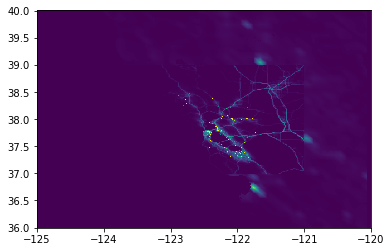

In [86]:
plt.pcolor(lons, lats, X_hat_integrated_grid[10], vmin=0, vmax=10)

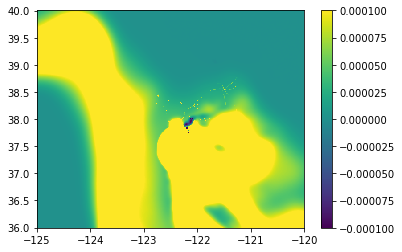

In [91]:
index = 10
h = plt.pcolor(lons, lats, X_hat_integrated_grid[index]-X_prior_integated[index], vmin=-0.0001, vmax=0.0001)
plt.colorbar(h)

# Python Module testing

In [2]:
from diagPrior.time_resolved_diag_prior import InversionDiagPrior
from Utils.getData import *
from config import *

Mode: resolved
Device: cpu
Start date: 2018-01-04 00:00:00
End date: 2018-01-05 00:00:00
Inversion grid: ([-123.1, -121.8], [37.35, 38.4])
490646 27049
Reading observation data ....


453it [02:53,  2.62it/s]


Loading emission data ....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:05<00:00, 16.31it/s]


In [3]:
invert = InversionDiagPrior(H, X, Y, So_d)
X_hat = invert.invert()
X_hat = X_hat.toarray()

In [11]:
X_hat_integrated_grid = np.zeros((int(invert.X_pri.shape[0]/m), nrow, ncol))
X_prior_integated = np.zeros((int(invert.X_pri.shape[0]/m), nrow, ncol))

for idx in range(X_hat_integrated_grid.shape[0]):
    X_hat_integrated_grid[idx, :, :] = make_grid_2d_column(X_hat[idx*m:(idx+1)*m], nrow, ncol)
    X_prior_integated[idx, :, :] = make_grid_2d_column(invert.X_pri_array[idx*m:(idx+1)*m], nrow, ncol)
    


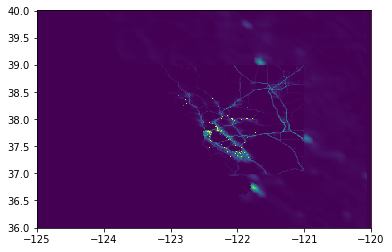

In [13]:
plt.pcolor(lons, lats, X_hat_integrated_grid[10], vmin=0, vmax=10)

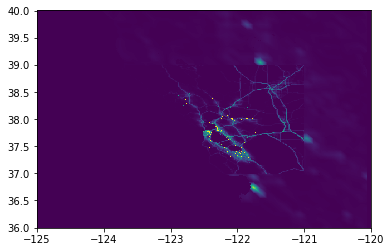

In [14]:
plt.pcolor(lons, lats, X_prior_integated[10], vmin=0, vmax=10)

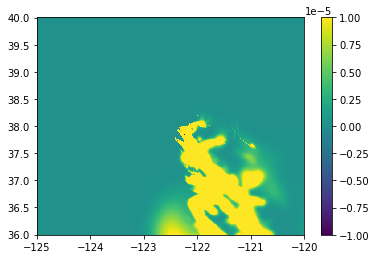

In [19]:
index = 10
h = plt.pcolor(lons, lats, X_hat_integrated_grid[index]-X_prior_integated[index], vmin=-0.00001, vmax=0.00001)
plt.colorbar(h)